## Deep Inverse Regression with Yelp reviews

In this note we'll use [gensim](http://radimrehurek.com/gensim/) to turn the Word2Vec machinery into a document classifier, as in [Document Classification by Inversion of Distributed Language Representations](http://arxiv.org/pdf/1504.07295v3) from ACL 2015.

### Data and prep

First, download to the same directory as this note the data from the [Yelp recruiting contest](https://www.kaggle.com/c/yelp-recruiting) on [kaggle](https://www.kaggle.com/):
* https://www.kaggle.com/c/yelp-recruiting/download/yelp_training_set.zip
* https://www.kaggle.com/c/yelp-recruiting/download/yelp_test_set.zip

You'll need to sign-up for kaggle.



You can then unpack the data and grab the information we need.  

We'll use an incredibly simple parser

In [1]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")


And put everything together in a review generator that provides tokenized sentences and the number of stars for every review.

In [2]:
from zipfile import ZipFile
import json

def YelpReviews(label):
    with ZipFile("yelp_%s_set.zip"%label, 'r') as zf:
        with zf.open("yelp_%s_set/yelp_%s_set_review.json"%(label,label)) as f:
            for line in f:
                rev = json.loads(line)
                yield {'y':rev['stars'],\
                       'x':[clean(s).split() for s in sentences(rev['text'])]}


For example:

In [3]:
YelpReviews("test").next()

{'x': [[u'nice', u'place', u'big', u'patio'],
  [u'now', u'offering', u'live', u'sketch', u'comedy'],
  [u'wednesday',
   u'november',
   u'17th',
   u'see',
   u'local',
   u'troupe',
   u'th',
   u'sic',
   u'sense',
   u'in',
   u'their',
   u'2nd',
   u'annual',
   u'holiday',
   u'show'],
  [u'lighter', u'snappier', u'take', u'on', u'the', u'holiday', u'times'],
  [u'not', u'for', u'the', u'easily', u'offended'],
  [u'sketches',
   u'include',
   u'the',
   u'scariest',
   u'holloween',
   u'costume',
   u'the',
   u'first',
   u'thanksgiving',
   u'and',
   u'who',
   u'shot',
   u'santa',
   u'claus'],
  [u'as',
   u'well',
   u'as',
   u'the',
   u'infectious',
   u'song',
   u'mama',
   u'christmas']],
 'y': 5}

Now, since the files are small we'll just read everything into in-memory lists.  It takes a minute ...

In [4]:
revtrain = list(YelpReviews("training"))
print len(revtrain), "training reviews"

## and shuffle just in case they are ordered
import numpy as np
np.random.shuffle(revtrain)

229907 training reviews


Finally, write a function to generate sentences -- ordered lists of words -- from reviews that have certain star ratings

In [5]:
def StarSentences(reviews, stars=[1,2,3,4,5]):
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

### Word2Vec modeling

We fit out-of-the-box Word2Vec

In [6]:
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=3) # sweeps of SGD through the data; more is better
print basemodel

Word2Vec(vocab=0, size=100, alpha=0.025)


Build vocab from all sentences (you could also pre-train the base model from a neutral or un-labeled vocabulary)

In [7]:
basemodel.build_vocab(StarSentences(revtrain))  

Now, we will _deep_ copy each base model and do star-specific training. This is where the big computations happen...

In [8]:
from copy import deepcopy
starmodels = [deepcopy(basemodel) for i in range(5)]
for i in range(5):
    slist = list(StarSentences(revtrain, [i+1]))
    print i+1, "stars (", len(slist), ")"
    starmodels[i].train(  slist, total_examples=len(slist) )
    

1 stars ( 246207 )
2 stars ( 295371 )
3 stars ( 437718 )
4 stars ( 883235 )
5 stars ( 799704 )


### Inversion of the distributed representations

At this point, we have 5 different word2vec language representations.  Each 'model' has been trained conditional (i.e., limited to) text from a specific star rating.  We will apply Bayes rule to go from _p(text|stars)_ to _p(stars|text)_.

Fo any new sentence we can obtain its _likelihood_ (lhd; actually, the composite likelihood approximation; see the paper) using the [score](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.score) function in the `word2vec` class.  We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings.  This is all in the following handy wrapper.

In [9]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""

import pandas as pd # for quick summing within doc

def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob


#### Test set example

As an example, we apply the inversion on the full test set.  

In [10]:
# read in the test set
revtest = list(YelpReviews("test"))

In [11]:
# get the probs (note we give docprob a list of lists of words, plus the models)
probs = docprob( [r['x'] for r in revtest], starmodels )

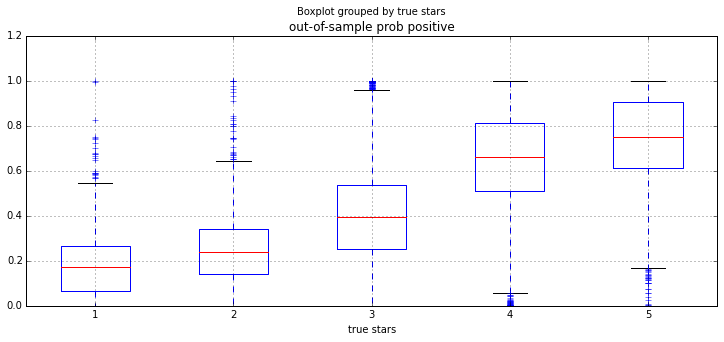

In [12]:
%matplotlib inline

probpos = pd.DataFrame({"out-of-sample prob positive":probs[[3,4]].sum(axis=1), 
                        "true stars":[r['y'] for r in revtest]})
probpos.boxplot("out-of-sample prob positive",by="true stars", figsize=(12,5))